# Imports

In [1]:
%matplotlib notebook
import loc_utils as lut
import vis_utils as vut
from standards import *
r = RAWix()

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.formula.api as smf

from IPython.display import display
import ipywidgets as wid

colors = ['#43799d', '#cc5b46', '#ffbb00', '#71bc78']
tlabels = {
        1: '1D',
        2: 'I1D',
        3: '2D',
        4: 'R'}

# Parametric model of hits

,grp,sid,trial,tid,cor,blkt,ntm
0,0,0,1,3,0,0,3
1,0,0,2,3,0,1,3
2,0,0,3,3,0,2,3
3,0,0,4,3,1,3,3
4,0,0,5,3,0,4,3


<IPython.core.display.Javascript object>


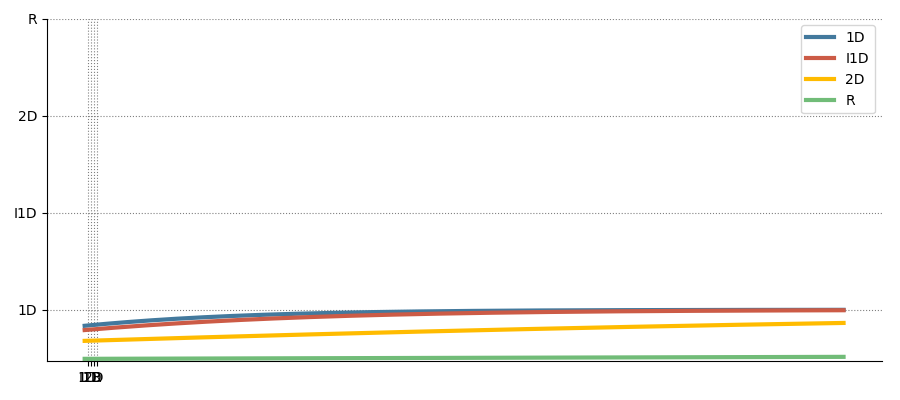

Optimization terminated successfully.
         Current function value: 0.383643
         Iterations 7
1D: log_odds(hit) = 1.598 + 0.022 x TRIAL
Optimization terminated successfully.
         Current function value: 0.456049
         Iterations 7
I1D: log_odds(hit) = 1.314 + 0.016 x TRIAL
Optimization terminated successfully.
         Current function value: 0.610795
         Iterations 5
2D: log_odds(hit) = 0.747 + 0.004 x TRIAL
Optimization terminated successfully.
         Current function value: 0.693113
         Iterations 3
R: log_odds(hit) = -0.022 + 0.000 x TRIAL


In [15]:
rt_path = 'pipeline_data/s3/joint_data.pkl' 
ntm_path = 'pipeline_data/clear_data/ntm_data_freeplay.pkl'

arrdata = lut.unpickle(rt_path)['main'][:, [r.ix('group'),r.ix('sid'),r.ix('trial'),r.ix('cat'),r.ix('cor'),r.ix('blkt')]]

df_dict = {}
for i, (col, dt) in enumerate(zip('grp,sid,trial,tid,cor,blkt'.split(','), [int,int,int,int,int,int])):
    df_dict[col] = pd.Series(arrdata[:, i], dtype=dt)

df = pd.DataFrame(df_dict)
ntm_df = lut.unpickle(ntm_path)[['sid','ntm']].groupby('sid').head(1)
df = df.merge(ntm_df, on='sid').drop_duplicates()
del ntm_df, arrdata

df = df.loc[df.ntm==3, :]
display(df.head(5))

fig = plt.figure('Hits model', figsize=[9, 4])
ax = vut.pretty(fig.add_subplot(111))

coefs = {}
for tid in [1,2,3,4]:
    tdf = df.loc[df.tid==tid, :]
    m = smf.logit('cor ~ blkt', data=tdf).fit()
#     display(m.summary())
    b0, b1 = m.params['Intercept'], m.params['blkt']
    coefs[tid] = np.array([b0, b1])
    
    x_trial = np.arange(1, 250)
    y_hat = []
    x_intercept = np.ones_like(x_trial)
    X = pd.DataFrame({'Intercept': x_intercept, 'blkt': x_trial})
    y_hat = m.predict(X)
    ax.plot(y_hat, label=tlabels[tid], color=colors[tid-1], lw=3)
    print('{0}: log_odds(hit) = {1:.3f} + {2:.3f} x TRIAL'.format(tlabels[tid], b0, b1))
    
ax.legend()
fig.tight_layout()

def pmod(trial, tid):
    b0, b1 = coefs[tid]
    prob = 1 / (1 + np.exp(-(b0 + b1*trial)))
    try:
        iter(trial)
        return (np.random.rand(trial.size) <= prob).astype(int)
    except TypeError as te:
        return int(np.random.rand() <= prob)

# Nonparametric model of hits

,grp,sid,trial,tid,cor,blkt,ntm
0,0,0,1,3,0,0,3
1,0,0,2,3,0,1,3
2,0,0,3,3,0,2,3
3,0,0,4,3,1,3,3
4,0,0,5,3,0,4,3


<IPython.core.display.Javascript object>


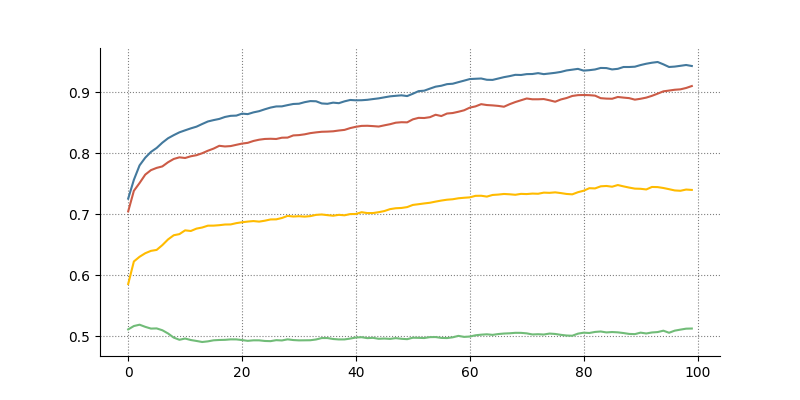

In [14]:
rt_path = 'pipeline_data/s3/joint_data.pkl' 
ntm_path = 'pipeline_data/clear_data/ntm_data_freeplay.pkl'

arrdata = lut.unpickle(rt_path)['main'][:, [r.ix('group'),r.ix('sid'),r.ix('trial'),r.ix('cat'),r.ix('cor'),r.ix('blkt')]]

df_dict = {}
for i, (col, dt) in enumerate(zip('grp,sid,trial,tid,cor,blkt'.split(','), [int,int,int,int,int,int])):
    df_dict[col] = pd.Series(arrdata[:, i], dtype=dt)

df = pd.DataFrame(df_dict)
ntm_df = lut.unpickle(ntm_path)[['sid','ntm']].groupby('sid').head(1)
df = df.merge(ntm_df, on='sid').drop_duplicates()
del ntm_df, arrdata

df = df.loc[df.ntm==3, :]
display(df.head(5))

grouped = df.groupby(['tid', 'blkt'])[['cor']].mean()
fig = plt.figure('Nonparam', figsize=[8,4])
ax = vut.pretty(fig.add_subplot(111))

probs = np.zeros([4, 100])
for tid in [1,2,3,4]:
    y = grouped.loc[(tid, slice(None)), :].rolling(50, min_periods=1).mean().values.squeeze()
    ax.plot(y[:100], color=colors[tid-1])
    probs[tid-1, :] = y[:100]
    
def npmod(trials, tid):
    t = trials.copy()
    t[t <= 0] = 0
    t[t >= 100] = 99
    p = probs[tid-1, t]
    return (np.random.rand(t.size) <= p).astype(int)

# Simulation

<IPython.core.display.Javascript object>


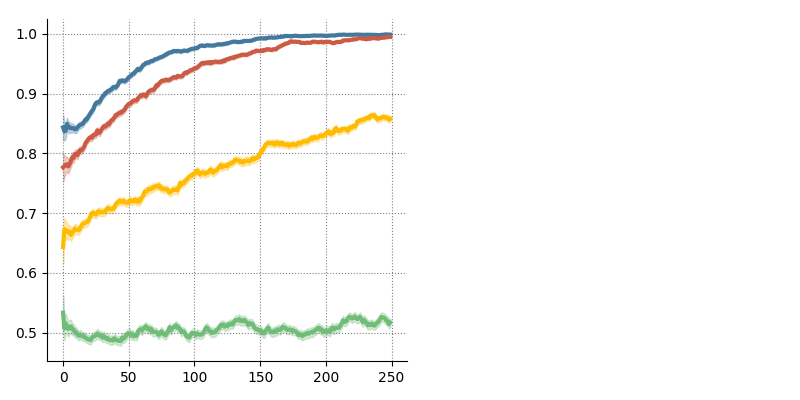

In [316]:
fig = plt.figure('Hits simulation', figsize=[8, 4])
ax = vut.pretty(fig.add_subplot(121))
# ax.set_xlim(0,50)
# ax.set_ylim(.45,.9)

trials = np.arange(0, 250)
N = 300
for tid in [1,2,3,4]:
    group = []
    for sid in range(N):
        hits = pmod(trials, tid) # Use parametric model to generate hits
#         hits = npmod(trials, tid) # Use nonparametric model to generate hits
        hit_rate = pd.Series(hits).rolling(15, min_periods=1).mean()
        group.append(hit_rate)
    group = np.stack(group, axis=0)
    y = group.mean(axis=0)
    yerr = group.std(axis=0)/np.sqrt(N-1)
    ax.plot(trials, y, label=tlabels[tid], color=colors[tid-1], lw=3)
    ax.fill_between(trials, y+yerr, y-yerr, color=colors[tid-1], alpha=.3)
    
fig.tight_layout()

# Utility function and its parameters

In [182]:
def dummy(n, i):
    dummy = np.zeros(n)
    dummy[i] = 1
    return dummy


def utility(x, alpha=1, beta=1, gamma=0):
    ''' Utility function
    x must be a row (or an array of rows) 
    containing 3 values: LP, PC, and I '''
    return np.sum(x * np.array([alpha, beta, gamma]), axis=1)


def softmax(U):
    return np.exp(U) / np.sum(np.exp(U))


def choose(a, det=False):
    ''' Choice function
    if det  : choose an option with maximum utility
    if !det : choose an option probabilistically, in proportion to utility'''
    if det:
        return np.argmax(a)
    else:
        cum_probs = np.cumsum(a, axis=0)
        rand = np.random.rand(a.shape[-1])
        return (rand<cum_probs).argmax()


def simulate(X, N_trials, alpha, beta, gamma, memcap, lpwin):
    counter = np.array([1, 1, 1, 1])
    mem = X.values.copy()[-memcap:, :]
    init_pc = np.mean(mem, axis=0)
    init_lp = np.abs(mem[:-lpwin, :].mean(axis=0) - mem[-lpwin:, :].mean(axis=0))
    init_in = np.zeros_like(init_pc)
    lps, pcs = [init_lp], [init_pc] 
    util = []
    choices, hits = np.zeros(N_trials), np.zeros(N_trials)
    
    for t in range(N_trials):
        # Compute utility based on state x, choose the next task based on utility, 
        # and get feedback by playing the task
        U = utility(x, alpha=alpha, beta=beta, gamma=gamma)
        i = choose(softmax(U), det=False)
        counter[i] += 1
        hit = pmod(counter[i], i+1)
        
        # ========== Update memory ==========
        # 1. Update last choice
        x[:, 2] = 0 
        x[i, 2] = 1
        
        # 2. Update hits memory
        mem[:-1, :] = mem[1:, :]
        mem[-1, i] = hit
        
        # 3. Update expected reward (PC)
        pc_vect = np.mean(mem, axis=0)
        x[i, 1] = pc_vect[i] # PC
        
        # 4. Update LP
        lp_vect = np.abs(mem[:-lpwin, :].mean(axis=0) - mem[-lpwin:, :].mean(axis=0))
        x[i, 0] = lp_vect[i] # LP
        
        # ========== Record data ============
        pcs.append(pc_vect)
        lps.append(lp_vect)
        util.append(U)
        choices[t] = i
        hits[t] = hit
    
    return counter/np.sum(counter), pcs, lps, choices, hits, util


def get_sub_data(sid=None, ntm=None, grp=None):
    arrdata = lut.unpickle('pipeline_data/s3/joint_data.pkl')['main'][:, [r.ix('group'),r.ix('sid'),r.ix('trial'),r.ix('cat'),r.ix('cor'),r.ix('blkt')]]
    df_dict = {}
    for i, (col, dt) in enumerate(zip('grp,sid,trial,tid,cor,blkt'.split(','), [int,int,int,int,int,int])):
        df_dict[col] = pd.Series(arrdata[:, i], dtype=dt)
    df = pd.DataFrame(df_dict)
    
    ntm_df = lut.unpickle(ntm_path)[['sid','ntm']].groupby('sid').head(1)
    df = df.merge(ntm_df, on='sid').drop_duplicates()
    del ntm_df, arrdata
    df = df.loc[df.trial<=60]
    
    if ntm: df = df.loc[df.ntm==ntm, :]
    if grp: df = df.loc[df.grp==grp, :]
    if sid: 
        df = df.loc[df.sid==sid, :]
    else:
        sid = np.random.choice(df.sid.unique())
        df = df.loc[df.sid==sid, :]
    print('SID: {}'.format(sid))
        
    df = df.loc[:, ['blkt','tid','cor']].pivot(index='blkt', columns='tid', values='cor')
    return df

## Utility function (run cell 5 1st)

SID: 56


<IPython.core.display.Javascript object>


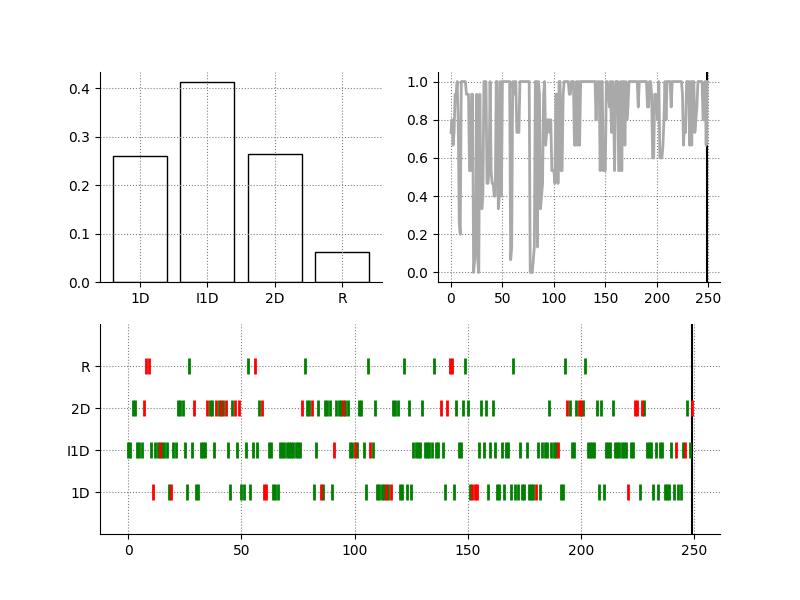

interactive(children=(IntSlider(value=249, continuous_update=False, description='trial', layout=Layout(width='…

In [187]:
def plot_sim(X, t, alpha, beta, gamma, ax1, ax2, seed=1):
    np.random.seed(seed)
    tot, pc, lp, choices, hits, util = simulate(X, N, alpha, beta, gamma, memcap=15, lpwin=1)
    if len(ax1.findobj(match=mpl.patches.Rectangle)) > 1: 
        for _ in probs: ax1.findobj(match=mpl.patches.Rectangle)[0].remove()
    rects = ax1.bar(np.arange(X.shape[1]), tot, color='white', edgecolor='k')
    
    while ax2.get_lines():
        ax2.get_lines()[0].remove()
    ax2.axvline(t, color='k')
    filt_pc = np.stack(pc, axis=0)[np.arange(len(pc)-1), choices.astype(int)]
    ax2.plot(filt_pc, c='darkgray', lw=2)
    
    while ax3.get_lines():
        ax3.get_lines()[0].remove()
    ax3.axvline(t, color='k')
    inds = np.arange(choices.size)
    hmask = hits.astype(bool)
    ax3.plot(inds[hmask], choices[hmask]+1, c='green', marker='|', ls='', ms=12, mew=2)
    ax3.plot(inds[~hmask], choices[~hmask]+1, c='red', marker='|', ls='', ms=12, mew=2)
    
    choices_binary = np.zeros([choices.size, 4])
    choices_binary[np.arange(choices.size), choices.astype(int)] = 1
    NA = ['N/A','N/A','N/A','N/A']
    nohit = [False, False, False, False]
    out = pd.DataFrame({
        'tid': np.arange(K)+1, 
        'LP(t-)': lp[t], 
        'PC(t-)': pc[t], 
        'I(t-)': choices_binary[t-1, :].astype(int) if t else np.zeros(K).astype(int),
        'utility(t)': util[t],
        'p(t)': softmax(util[t]),
        'choice(t)': choices_binary[t, :].astype(bool),
        'hit(t)': choices_binary[t, :].astype(bool) if hits[t] else nohit,
        'LP(t+)': lp[t+1], 
        'PC(t+)': pc[t+1], 
    }).set_index('tid')
    display(out)
    
K = 4 # number of tasks
# X = pd.DataFrame({'tid': list(range(K)), 
#                   'lp': [.1, .1, .1, .1], 
#                   'pc': [.7, .6, .5, .5] , 
#                   'in': [0, 0, 0, 0]})
X = get_sub_data(sid=0, ntm=3)
N = 250
live = True if N < 100 else False

fig = plt.figure('Utility and params', figsize=[8,6])
ax1 = vut.pretty(fig.add_subplot(221)); ax1.set_xticks([0,1,2,3]); ax1.set_xticklabels([tlabels[i] for i in [1,2,3,4]])
ax2 = vut.pretty(fig.add_subplot(222))
ax3 = vut.pretty(fig.add_subplot(212)); ax3.set_ylim(0, 5); ax3.set_yticks([1,2,3,4]); ax3.set_yticklabels([tlabels[i] for i in [1,2,3,4]])
alpha_ = wid.FloatSlider(min=-10, max=10, value=1, description='alpha', continuous_update=live, layout=wid.Layout(width='80%'))
beta_  = wid.FloatSlider(min=-10, max=10, value=1, description='beta', continuous_update=live, layout=wid.Layout(width='80%'))
gamma_ = wid.FloatSlider(min=-10, max=10, value=1, description='gamma', continuous_update=live, layout=wid.Layout(width='80%'))
trial_ = wid.IntSlider(min=0, max=N-1, value=N-1, description='trial', continuous_update=live, layout=wid.Layout(width='80%'))
    
    
pd.options.display.float_format = '{:.3f}'.format
interactive_util = wid.interact(plot_sim, X=wid.fixed(X), t=trial_,
                                alpha=alpha_, beta=beta_, gamma=gamma_, 
                                ax1=wid.fixed(ax1), ax2=wid.fixed(ax2), ax3=wid.fixed(ax3),
                                seed=wid.fixed(2))

In [170]:
s = get_sub_data(sid=203)
display(s.mean(axis=0))

SID: 203


tid
1   0.800
2   0.800
3   0.867
4   0.400
dtype: float64